Loading MNIST...
Subset shape: (22164, 784), Classes: [3 5 7 9]
Test shape: (5541, 784), Classes: [3 5 7 9]
Train shape: (22164, 784), Classes: [3 5 7 9]
GLVQ Accuracy: 0.8958671719906154

Classification Report:
               precision    recall  f1-score   support

           3       0.87      0.95      0.91      1444
           5       0.96      0.84      0.90      1232
           7       0.86      0.94      0.90      1463
           9       0.92      0.84      0.88      1402

    accuracy                           0.90      5541
   macro avg       0.90      0.89      0.90      5541
weighted avg       0.90      0.90      0.90      5541



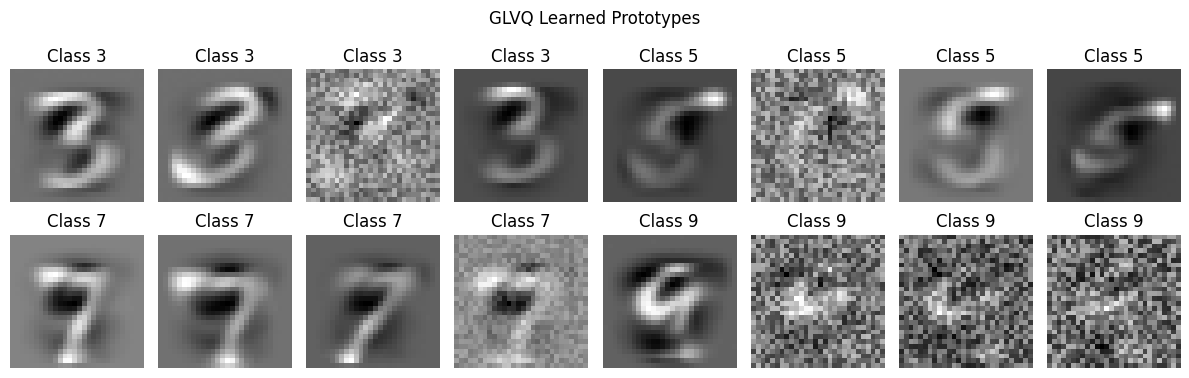

In [ ]:

# 1. Import Libraries
import numpy as np
import matplotlib.pyplot as plt
#from datasets import load_dataset
#from sklearn.preprocessing import StandardScaler


#from sklearn_lvq import GlvqModel
from ceml.sklearn.lvq import LvqCounterfactual, lvq_generate_counterfactual
from sklearn.metrics import accuracy_score, classification_report

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_lvq import GlvqModel
from sklearn.metrics import accuracy_score

# Load full MNIST dataset
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

# Convert labels to integers
y = y.astype(int)


# 2. Select only digits 3, 5, 7, 9
target_digits = [3, 5, 7, 9]
subset_indices = np.isin(y, target_digits)
X_subset, y_subset = X[subset_indices], y[subset_indices]



# 4. Normalize pixel values to [0, 1]
X_subset = X_subset.astype(np.float32) / 255.0

# 5. Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_subset, test_size=0.2, random_state=42
)

print(f"Subset shape: {X_train.shape}, Classes: {np.unique(y_train)}")
print(f"Test shape: {X_test.shape}, Classes: {np.unique(y_test)}")
print(f"Train shape: {X_train.shape}, Classes: {np.unique(y_train)}")


# 5. Create and Train GLVQ Model
glvq = GlvqModel(prototypes_per_class=4, max_iter=1000, random_state=42)
# Save the original _optimize method
original_optimize = glvq._optimize

# Create a patched version that flattens the prototypes
def patched_optimize(x, y, random_state):
    # Save the original shape of the prototypes
    original_shape = glvq.w_.shape
    # Flatten the prototypes for optimization
    glvq.w_ = glvq.w_.ravel()
    # Call the original optimization method (which updates model.w_ in place)
    original_optimize(x, y, random_state)
    # Reshape the optimized prototypes back to their original shape
    glvq.w_ = glvq.w_.reshape(original_shape)


glvq._optimize = patched_optimize
glvq.fit(X_train, y_train)

# 6. Evaluate
y_pred = glvq.predict(X_test)
print("GLVQ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. Visualize learned prototypes
prototypes = glvq.w_.reshape(-1, 28, 28)
labels = glvq.c_w_

plt.figure(figsize=(12, 4))
for i in range(len(prototypes)):
    plt.subplot(2, len(prototypes) // 2, i + 1)
    plt.imshow(prototypes[i], cmap='gray')
    plt.title(f"Class {labels[i]}")
    plt.axis('off')
plt.suptitle("GLVQ Learned Prototypes")
plt.tight_layout()
plt.show()





In [2]:
from scipy.optimize import minimize
import numpy as np

def generate_cf_glvq_constrained(model, x_orig, y_target, C=1.0, epsilon=1e-3, bounds=None, verbose=False):
    """
    Generate counterfactual for GLVQ using proximity objective + hard margin constraint.

    Parameters:
    - model: trained GLVQ model
    - x_orig: original input sample (numpy array)
    - y_target: desired target class (int)
    - C: proximity regularization weight (float)
    - epsilon: small positive constant for numerical stability (float)
    - bounds: optional bounds for input features (list of tuples)
    - verbose: whether to print debug info

    Returns:
    - x_cf: counterfactual input (numpy array)
    - delta: change applied to original input (numpy array)
    - m_val: final margin value (float)
    """
    prototypes = model.w_
    labels = model.c_w_

    if not any(c == y_target for c in labels):
        raise ValueError(f"No prototype for target class {y_target}")

    def closest_dist(x, cls):
        dists = [np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c == cls]
        return min(dists)

    def margin(x):
        d_plus = closest_dist(x, y_target)
        d_minus = min(np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c != y_target)
        denom = d_plus + d_minus + epsilon
        return (d_plus - d_minus) / denom

    def loss(x):
        # Only proximity term
        prox = C * np.sum((x - x_orig) ** 2)
        return prox

    if bounds is None:
        bounds = [(-3, 3)] * len(x_orig)

    constraints = [
        {'type': 'ineq', 'fun': lambda x: -margin(x)}  # margin(x) <= 0
    ]

    result = minimize(
        loss,
        x0=x_orig,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )

    if result.success:
        x_cf = result.x
        delta = x_cf - x_orig
        m_val = margin(x_cf)
        if verbose:
            print(f"CF found. Margin: {m_val:.6f}, Δ norm: {np.linalg.norm(delta):.4f}")
        return x_cf, delta, m_val
    else:
        if verbose:
            print(f"Optimization failed: {result.message}")
        return None, None, None


In [3]:
# === Counterfactual generation loop ===
cf_data = []
success_count = 0
sample_indices = range(100)

for idx in sample_indices:
    x_sample = X_test[idx]
    y_orig = glvq.predict([x_sample])[0]

    if y_orig == 3:
        print(f"Skipping index {idx} because original class is already 3")
        continue

    y_target = 3

    x_cf, delta, m_val = generate_cf_glvq_constrained(glvq, x_sample, y_target, C=1.0)

    if x_cf is not None:
        y_cf = glvq.predict([x_cf])[0]
        if y_cf == y_target:
            print(f" CF index {idx}: flip to {y_target}, margin ≈ {m_val:.6f}, Δ norm = {np.linalg.norm(delta):.4f}")
            cf_data.append((x_sample, x_cf, delta, y_orig, y_cf))
            success_count += 1
        else:
            print(f" CF index {idx}: no flip (pred = {y_cf}), margin ≈ {m_val:.6f}")
    else:
        print(f" CF index {idx}: optimization failed")

❌ CF index 0: no flip (pred = 9), margin ≈ 0.000000
⚠ Skipping index 1 because original class is already 3
⚠ Skipping index 2 because original class is already 3
✅ CF index 3: flip to 3, margin ≈ -0.000000, Δ norm = 16.0170
⚠ Skipping index 4 because original class is already 3
⚠ Skipping index 5 because original class is already 3
❌ CF index 6: no flip (pred = 7), margin ≈ 0.000000
✅ CF index 7: flip to 3, margin ≈ -0.000000, Δ norm = 4.9743
⚠ Skipping index 8 because original class is already 3
⚠ Skipping index 9 because original class is already 3
⚠ Skipping index 10 because original class is already 3
✅ CF index 11: flip to 3, margin ≈ -0.000000, Δ norm = 19.1234
⚠ Skipping index 12 because original class is already 3
✅ CF index 13: flip to 3, margin ≈ -0.000000, Δ norm = 5.9008
✅ CF index 14: flip to 3, margin ≈ -0.000000, Δ norm = 0.1477
✅ CF index 15: flip to 3, margin ≈ -0.000000, Δ norm = 14.2890
⚠ Skipping index 16 because original class is already 3
⚠ Skipping index 17 becau

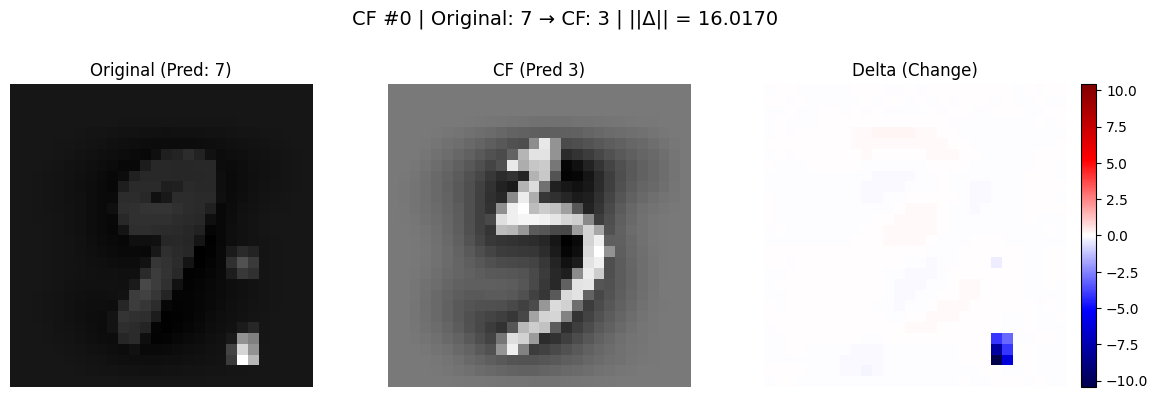

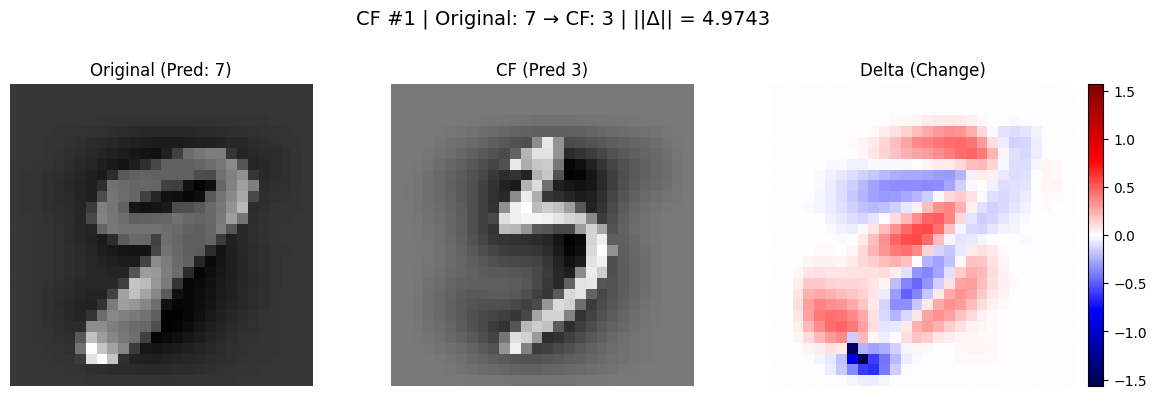

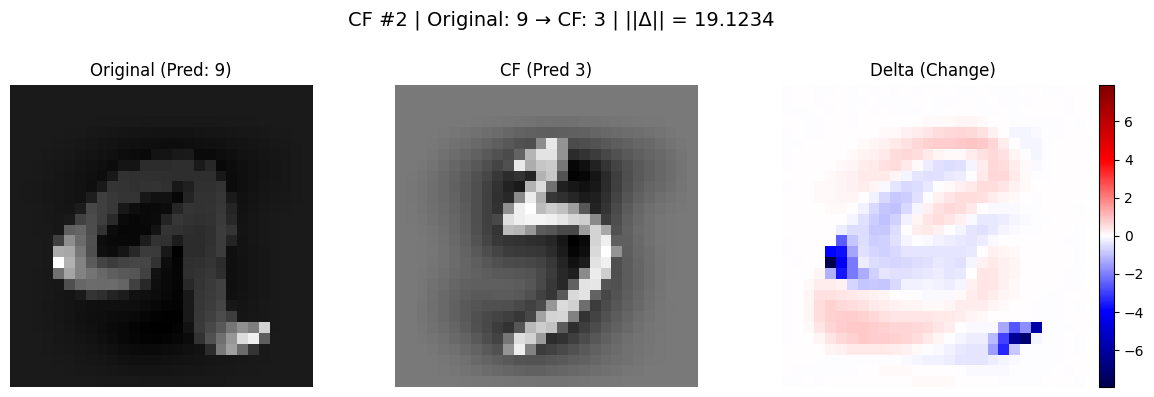

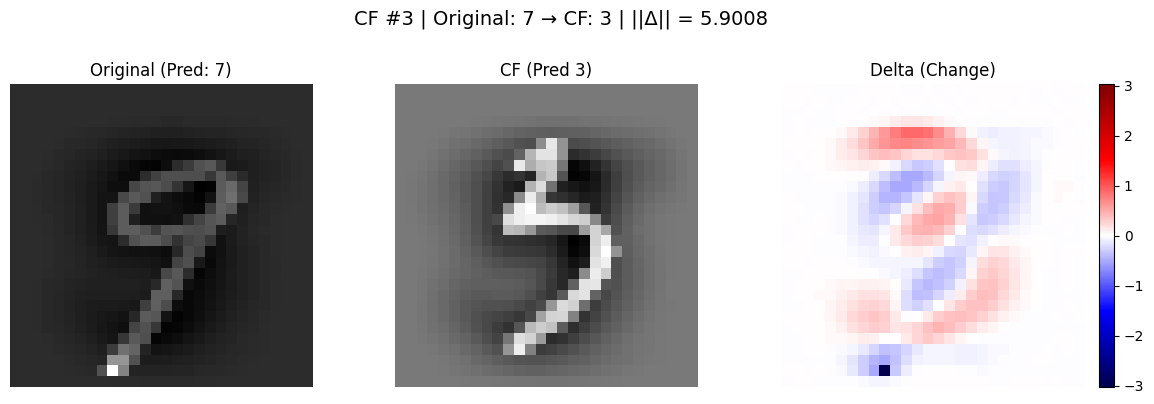

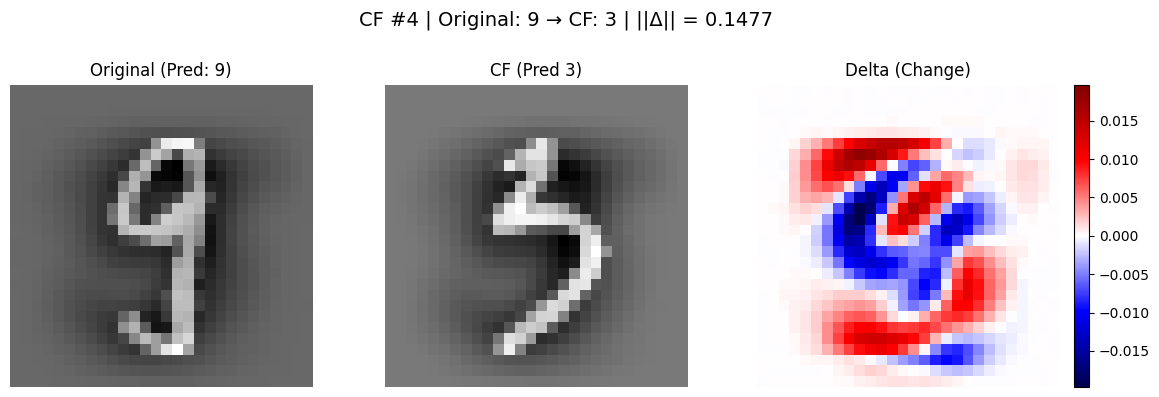

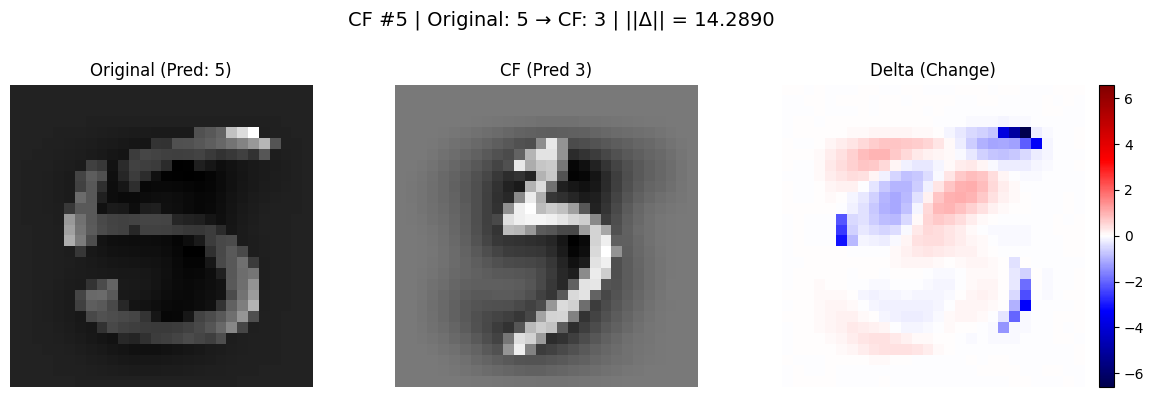

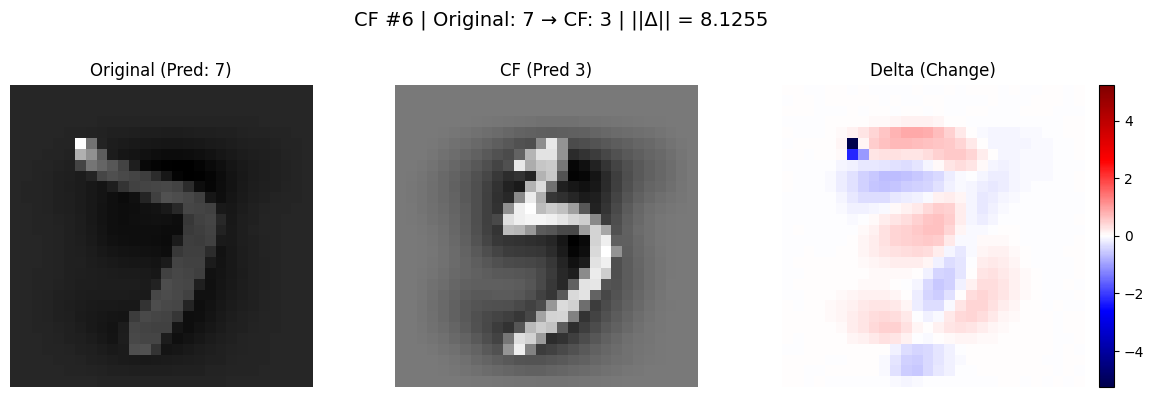

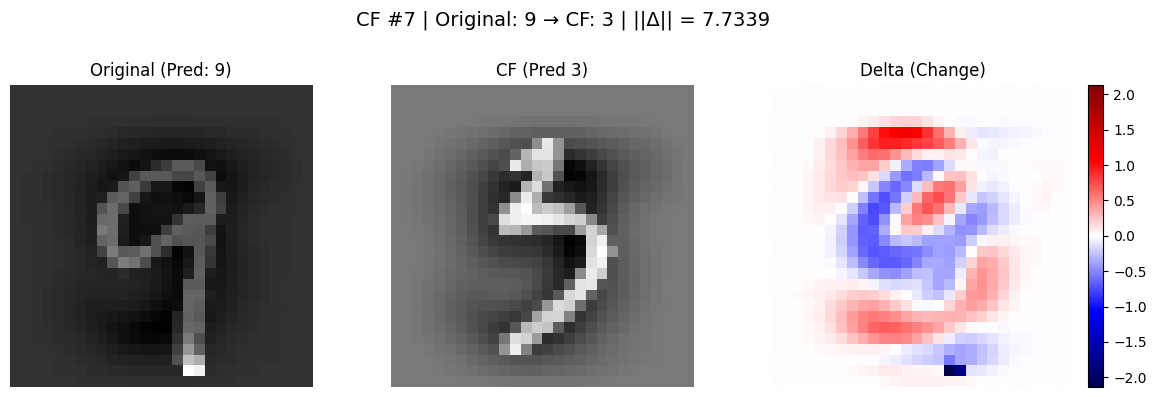

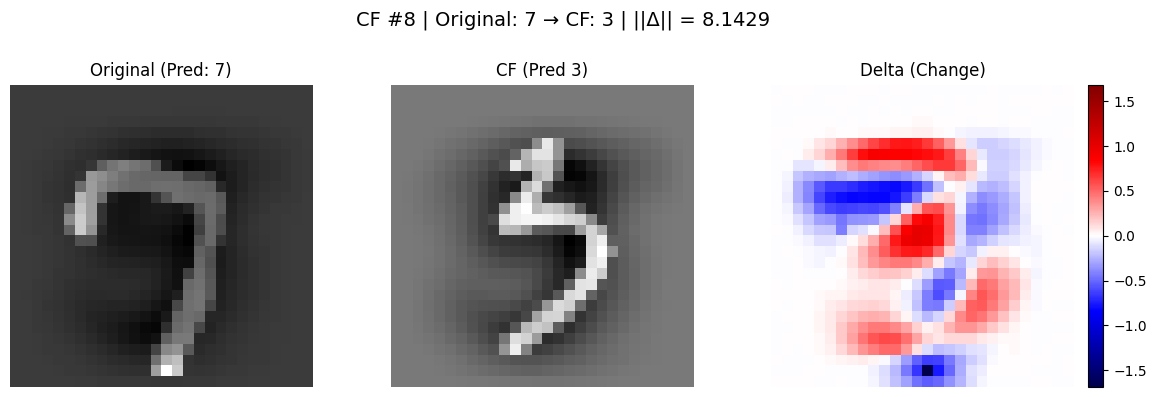

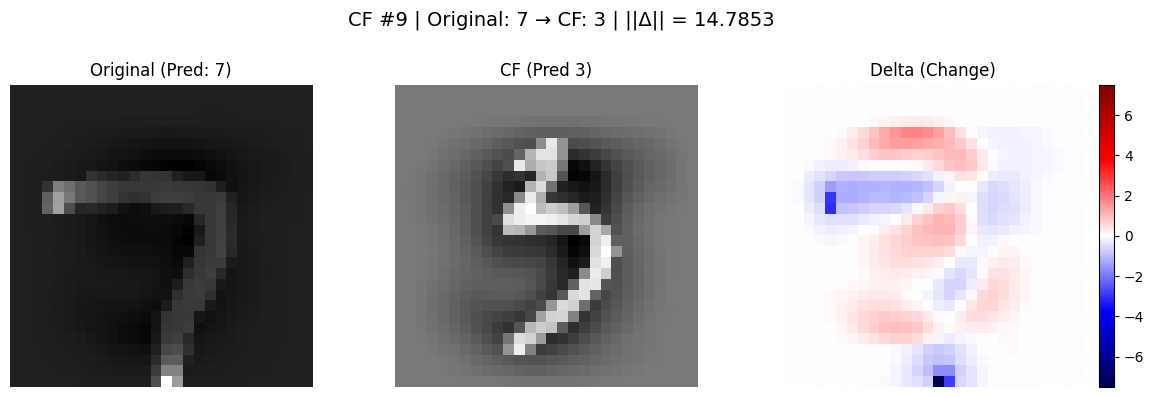

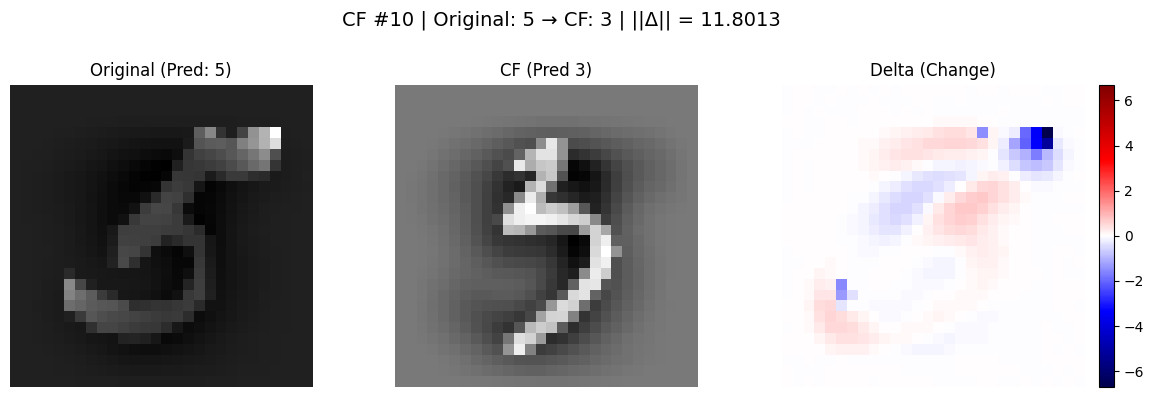

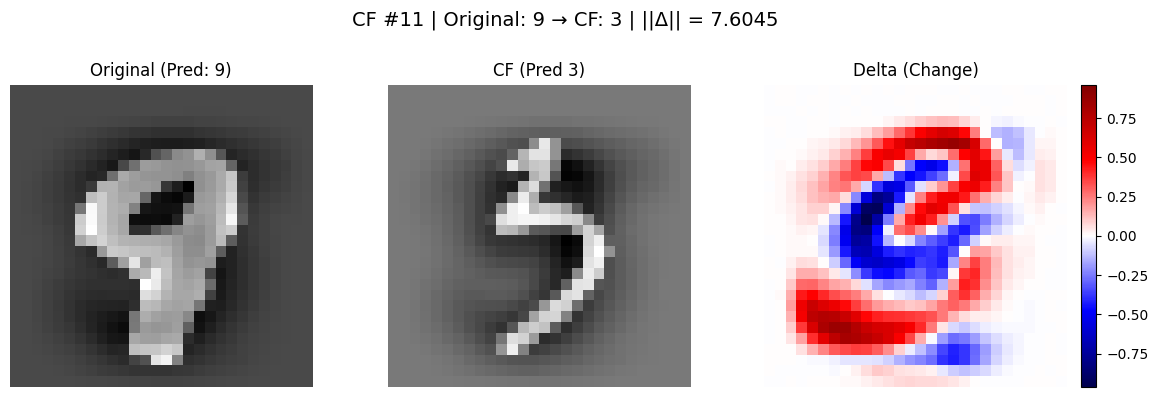

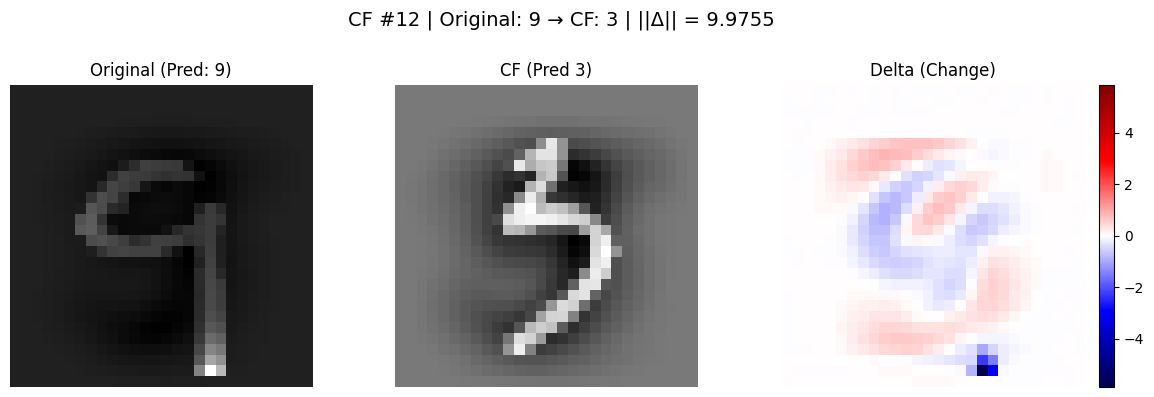

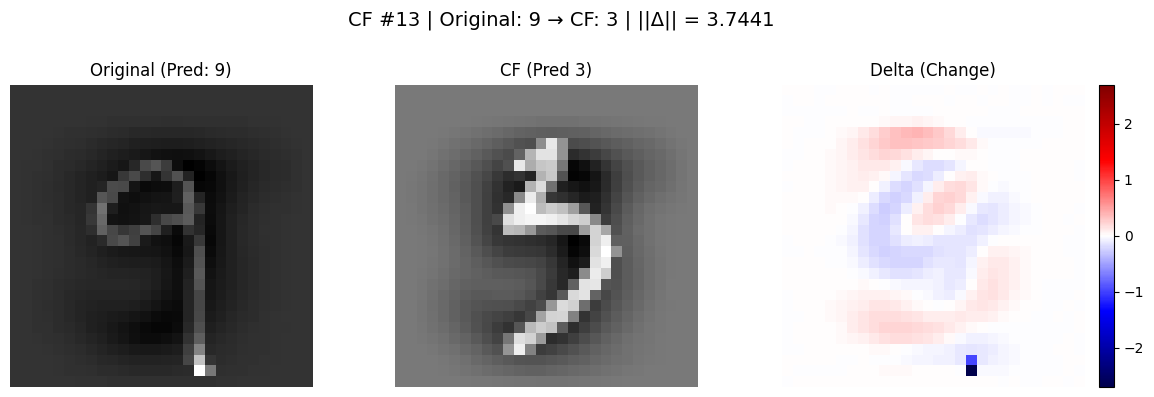

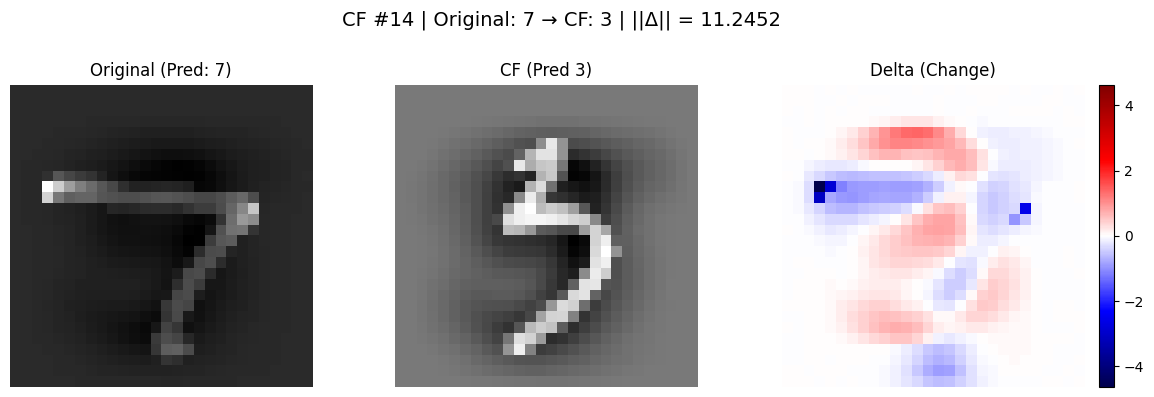

In [4]:
# Get one true "3" image from the test set
true_three_idx = np.where(y_test == 3)[0][0]
true_three_img = X_test[true_three_idx].reshape(28, 28)

for i, (x_orig, x_cf, delta, y_orig, y_cf) in enumerate(cf_data):
    img_orig = x_orig.reshape(28, 28)
    img_delta = delta.reshape(28, 28)
    max_val = np.abs(img_delta).max()
    delta_norm = np.linalg.norm(delta)

    plt.figure(figsize=(12, 4))  # Adjusted figure size

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title(f"Original (Pred: {y_orig})", fontsize=12)
    plt.axis("off")

    # Reference 3
    plt.subplot(1, 3, 2)
    plt.imshow(true_three_img, cmap='gray')
    plt.title("CF (Pred 3)", fontsize=12)
    plt.axis("off")

    # Delta
    plt.subplot(1, 3, 3)
    plt.imshow(img_delta, cmap='seismic', vmin=-max_val, vmax=max_val)
    plt.title("Delta (Change)", fontsize=12)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    # Overall title
    plt.suptitle(f"CF #{i} | Original: {y_orig} → CF: {y_cf} | ||Δ|| = {delta_norm:.4f}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leaves space for the suptitle
    plt.show()
